In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
from utils import ExchangeRatesReader
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import warnings

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use('seaborn')

In [3]:
warnings.simplefilter('ignore')

In [4]:
!pip3 install xlrd

    100% |################################| 112kB 175kB/s ta 0:00:01
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
reader = ExchangeRatesReader('./er_daily_2010-present.xls')

In [6]:
df = reader.to_dataframe()

In [7]:
df.head()

EUR  KZT  RUB      USD                дата*
2010 0  NaN  NaN  NaN  44.0917  2010-01-01 00:00:00
     1  NaN  NaN  NaN  44.0917  2010-01-04 00:00:00
     2  NaN  NaN  NaN  44.0917  2010-01-05 00:00:00
     3  NaN  NaN  NaN  44.0917  2010-01-06 00:00:00
     4  NaN  NaN  NaN  44.0917  2010-01-07 00:00:00

In [8]:
df.rename(columns={'дата*': 'date'}, inplace=True)

In [9]:
# need to remove all junk strings from the file
# TODO: this can be done in one function
def clean_junk_string(dataframe, column, inplace=False):
    print('Removing {} bad rows...'.format(dataframe[column].apply(lambda x: isinstance(x, str)).sum()))
    
    if inplace:
        return dataframe.drop(get_bad_indexes(dataframe[column]), inplace=True)
    else:
        return dataframe.drop(get_bad_indexes(dataframe[column]), inplace=False)

def get_bad_indexes(series):
    series_is_string = series.apply(lambda x: isinstance(x, str))
    series_non_string = series[series_is_string == True]
    return series_non_string.index

In [10]:
clean_junk_string(df, 'date', inplace=True)

Removing 25 bad rows...


In [11]:
df.index = df['date']

In [12]:
df.head()

,EUR,KZT,RUB,USD,date
date,,,,,
2010-01-01,NaN,NaN,NaN,44.0917,2010-01-01 00:00:00
2010-01-04,NaN,NaN,NaN,44.0917,2010-01-04 00:00:00
2010-01-05,NaN,NaN,NaN,44.0917,2010-01-05 00:00:00
2010-01-06,NaN,NaN,NaN,44.0917,2010-01-06 00:00:00
2010-01-07,NaN,NaN,NaN,44.0917,2010-01-07 00:00:00


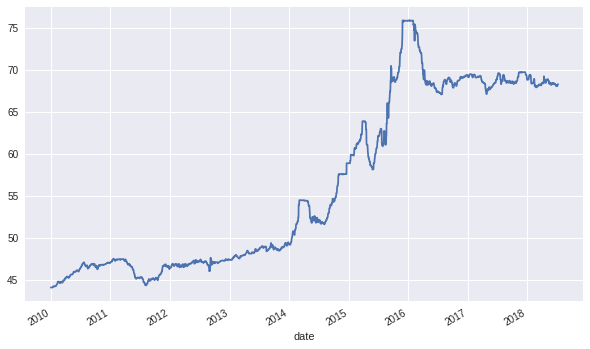

In [13]:
plt.figure(figsize=(10,6))
df['USD'].plot()

In [14]:
# Let's start with the basic smoothing
def moving_average(series, n):
    return np.average(series[-n:])

In [15]:
moving_average(df['USD'], 20)

68.20911000000001

In [16]:
def plot_moving_average(series, n):
    """ n - smoothing period """
    
    ma_series = []
    for i in range(series.shape[0]):
        res = moving_average(series[:i], n)
        ma_series.append(res)
        
    plt.plot(df['date'], ma_series, 'r')

In [17]:
def plot_moving_average_pandas_interface(series, n):
    """ n - smoothing period """
    
    
        
    plt.plot(df['date'], series.rolling(n).mean(), 'r')

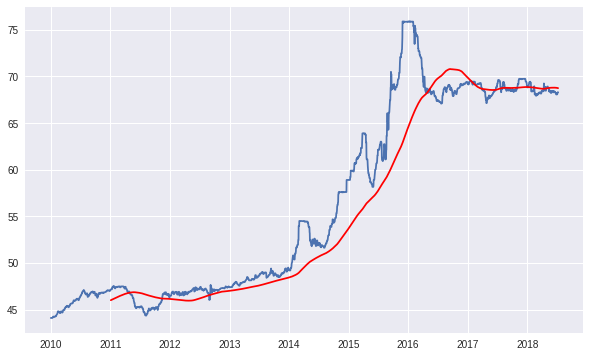

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['USD'])
plot_moving_average_pandas_interface(df['USD'], 365)

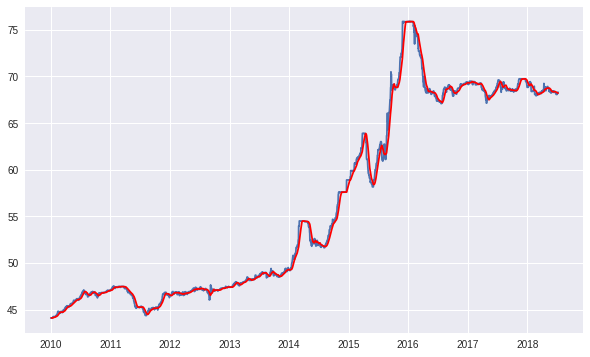

In [19]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['USD'])
plot_moving_average(df['USD'], 20)

## Double exponential smoothing (taking trend into account)

In [21]:
def double_exp_smoothing(series, alpha, beta): ## TODO: rewrite this to return a series, convenient for plotting
    """ predict series taking its trend into account
        alpha - smoothing factor
        beta - trend smoothing
    """
    level = 0
    trend = 0
    
    for i in range(series.shape[0]):
        if i == 0:
            level = alpha * series[i]
        else:
            level_prev = level
            level = alpha * series[i] + (1 - alpha) * (level + trend)
            trend = beta * (level - level_prev) + (1 - beta) * trend
    
    predicted = level + trend
    return predicted

In [22]:
double_exp_smoothing(df['USD'], 0.7, 0.7)

68.33571966466387

In [23]:
def double_exponential_smoothing_from_habr(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [24]:
double_exponential_smoothing_from_habr(df['USD'], 0.7, 0.7)[-2]

68.33571966466387

In [25]:
def plot_dexp_smoothing(series, alpha, beta):
    """ plots a double exponentially
    smoothed series
    n - smoothing period """
    
    predicted_series = []
    for i in range(series.shape[0]):
        res = double_exp_smoothing(series[:i+1], alpha, beta)
        predicted_series.append(res)
        
    plt.plot(df['date'], predicted_series, 'r')

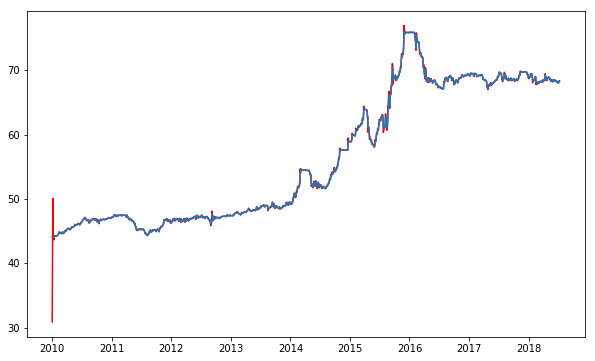

In [26]:
plt.figure(figsize=(10,6))
plot_dexp_smoothing(df['USD'], 0.7, 0.7)
plt.plot(df['date'], df['USD'])

## ARIMA

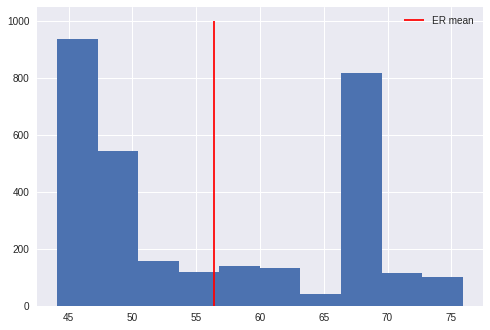

In [20]:
df['USD'].hist()
plt.vlines(df['USD'].mean(), 0, 1000, colors='r', label='ER mean')
plt.legend()

#### Coefficient of variation

In [21]:
print("{:.4f}".format(df['USD'].std() / df['USD'].mean()))

0.1820


We observe the large variance here relative to the series mean.

In [22]:
# Let's check stationarity of our series using Augmented Dickey-Fuller test
adfuller = sm.tsa.adfuller(df['USD'])
print('ADF: {:4f}'.format(adfuller[0]))
print('p-value: {:4f}'.format(adfuller[1]))
print('critical values: {}'.format(adfuller[4]))

if adfuller[0] > adfuller[4]['5%']:
    print('Series is not stationary')

else:
    print('Series is stationary')

ADF: -0.871246
p-value: 0.797294
critical values: {'5%': -2.8624791618529764, '10%': -2.5672699390416343, '1%': -3.4324756122601006}
Series is not stationary


In [23]:
er1diff = df['USD'].diff(periods=1).dropna()
er1diff.index = df['date'].index[1:]

In [24]:
adfuller = sm.tsa.adfuller(er1diff)
print('ADF: {:4f}'.format(adfuller[0]))
print('p-value: {:4f}'.format(adfuller[1]))
print('critical values: {}'.format(adfuller[4]))

if adfuller[0] > adfuller[4]['5%']:
    print('Series is not stationary')

else:
    print('Series is stationary')

ADF: -7.915132
p-value: 0.000000
critical values: {'5%': -2.8624791618529764, '10%': -2.5672699390416343, '1%': -3.4324756122601006}
Series is stationary


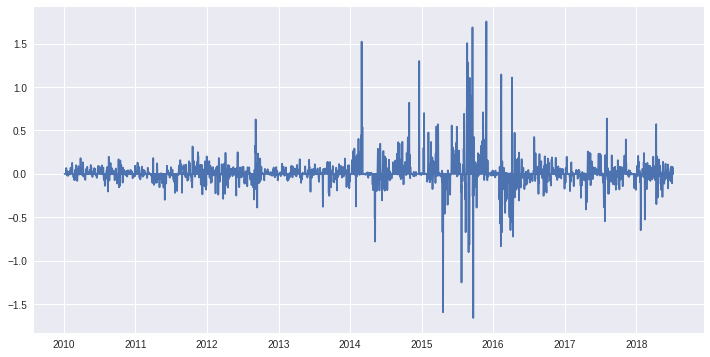

In [25]:
# Let's confirm stationarity of the 1st lag differences
plt.figure(figsize=(12,6))
plt.plot(df['date'][1:], er1diff)

In [26]:
# Let's compare the means to prove statioanarity in the first-lag differences
er1diff_part1 = er1diff['2010':'2014']
er1diff_part2 = er1diff['2015':'2018']
d1 = sm.stats.DescrStatsW(er1diff_part1)
d2 = sm.stats.DescrStatsW(er1diff_part2)

print('p-value: {}'.format(sm.stats.CompareMeans(d1,d2).ttest_ind()[1]))

p-value: 0.8761075499788329


The p-value for the null hypothesis of two means being equal can not be rejected. So, we can now say that our series is stationary. This is supported further by the absence of a trend on the graph above.
Thus, our original exchange rate series is a difference-stationary 1st-order series.

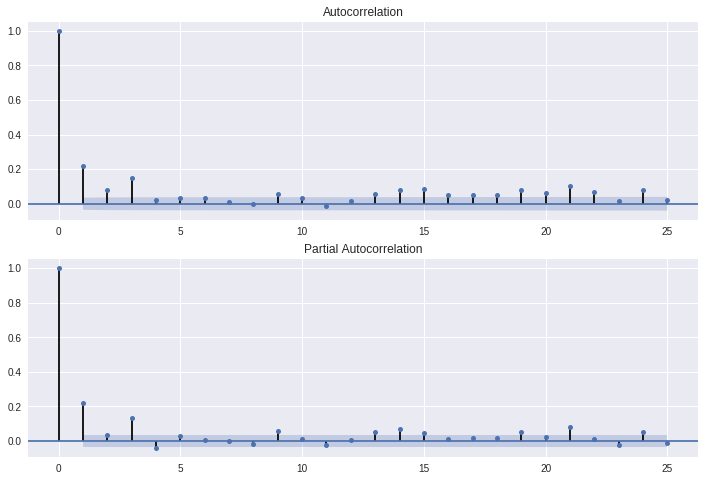

In [28]:
# We now turn to ARIMA(p,d,q) ,where we have found d already. d = 1 from the above
# To continue, we need p and q. For this, we will plot autocorrelation function and partial autocorrelation function.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(er1diff.values, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(er1diff.values, lags=25, ax=ax2)

We now see that our p = 1 and q = 1.

In [29]:
def ts_train_test_split(data, test_size):
    """
    Do the train-test split of a series
    
    Arguments:
    data -- time series array
    test_size -- float (between 0 and 1)
    
    Returns:
    train subset of data
    test subset of data
    """
    assert test_size >= 0 and test_size < 1
    return data[:int(data.shape[0] * (1-test_size))], data[int(data.shape[0] * (1-test_size)):]

In [30]:
train, test = ts_train_test_split(df['USD'], 0.18)

In [33]:
arima = sm.tsa.ARIMA(train, order=(1,1,1), freq='D')
arima_results = arima.fit()

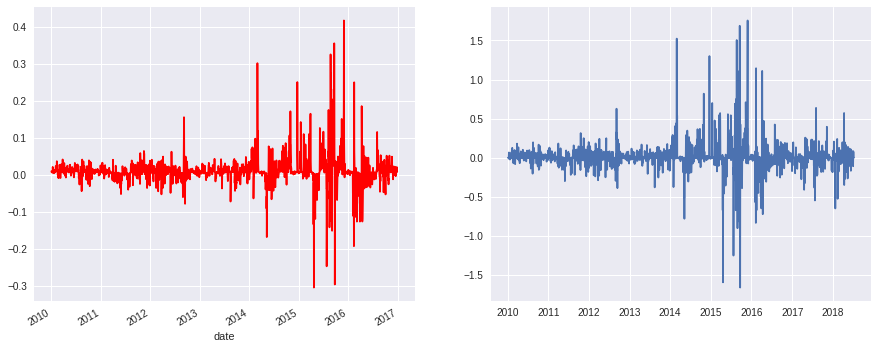

In [35]:
plt.figure(figsize=(15,6))
plt.subplot(121)
arima_results.fittedvalues.plot(c='r')
plt.subplot(122)
plt.plot(df['date'][1:], er1diff)

In [37]:
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.USD   No. Observations:                 2545
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1287.582
Method:                       css-mle   S.D. of innovations              0.146
Date:                Tue, 04 Dec 2018   AIC                          -2567.165
Time:                        15:04:10   BIC                          -2543.797
Sample:                    01-04-2010   HQIC                         -2558.689
                         - 12-26-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0099      0.004      2.288      0.022       0.001       0.018
ar.L1.D.USD     0.6268      0.067      9.357      0.000       0.495       0.758
ma.L1.D.USD    -0.4390      0.078     -5.640    

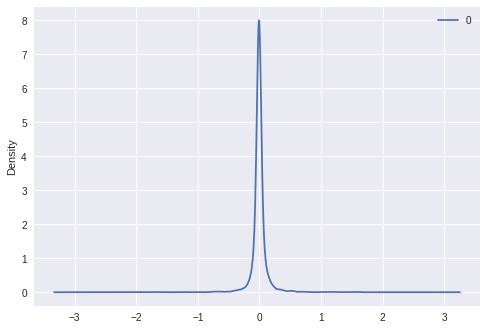

In [38]:
residuals = pd.DataFrame(arima_results.resid)
residuals.plot(kind='kde')

In [39]:
residuals.describe()

,0
count,2545.000000
mean,0.000002
std,0.145922
min,-1.685482
25%,-0.024513
50%,-0.006970
75%,0.014918
max,1.607472


In [40]:
predicted = arima_results.predict(start='2016-01-01', end='2016-12-31', typ='levels')

In [41]:
predicted_out_of_sample = arima_results.forecast(steps=365)[0]

In [43]:
predicted_out_of_sample = pd.Series(predicted_out_of_sample, index=df['USD']['2017'].index)

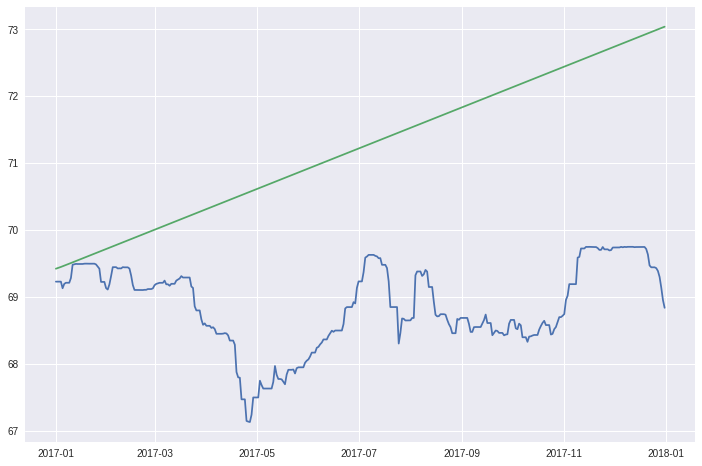

In [45]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017'])
plt.plot(predicted_out_of_sample)

As we see from the above, ARIMA(1,1,1) forecasts a straight line which does not take into account seasonality.

In [47]:
# rolling ARIMA forecasting of the exchange rate (model is refit each time a new observation is added)

def rolling_arima(train, test, params):
    """ returns rolling ARIMA estimates with each new data point added and the model refit
        train - initial data to fit ARIMA
        test - test data from which data points are added one by one and the model is refit
        params - tuple with ARIMA params (ARIMA(p,d,q))"""
    
    history = [x for x in train]
    rolling_predictions = []

    for i in range(len(test)):
        arima_model = sm.tsa.ARIMA(history, order=params, freq='D')
        arima_fit = arima_model.fit(disp=0)
        forecasted = arima_fit.forecast()[0]
        rolling_predictions.append(forecasted)
        obs = test[i]
        history.append(obs)
#         print(forecasted)
    
    return pd.Series(rolling_predictions, index=test.index)

In [48]:
%%time
rolling_predictions = rolling_arima(train, test, (1,1,1))

CPU times: user 3min 26s, sys: 2min 41s, total: 6min 8s
Wall time: 3min 4s


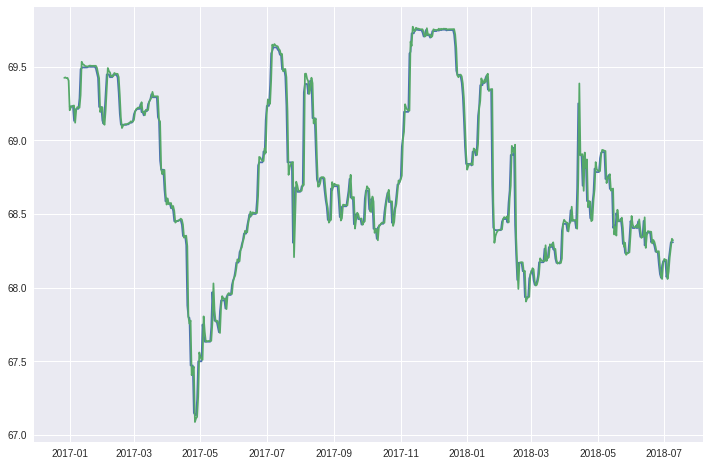

In [49]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017':])
plt.plot(rolling_predictions)

In [50]:
def difference(series, period):
    """ returns a differenced series """
    differenced = []
    
    for i in range(1, len(series)):
        diff = series[i] - series[i - period]
        differenced.append(diff)
    
    return np.array(differenced)

In [51]:
def inverse_difference(series, forecasted, period):
    """ transforms differenced back to an original array """
    return forecasted + series[-period]

In [53]:
first_differences = difference(train, 365)

In [54]:
arima = sm.tsa.ARIMA(first_differences, order=(1,1,1), freq='D')
arima_fit = arima.fit()

In [81]:
predicted = arima_fit.predict(start=1, end=100)

In [82]:
predicted_inverse = inverse_difference(train, predicted, 365)

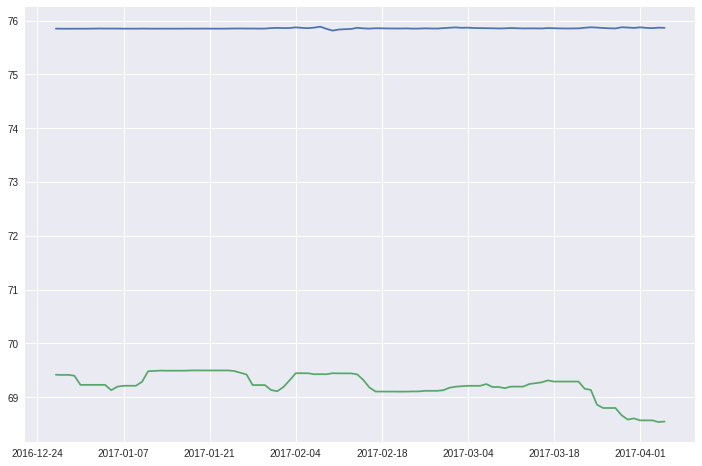

In [95]:
plt.figure(figsize=(12,8))
plt.plot(pd.Series(predicted_inverse, index=test.index[:100]))
plt.plot(test[:100])

In [ ]:
## things to add
# 1. box plot (capture seasonality around months)
# 2. plot correlation of the series with its lags
# 3. try log transformation of the series
# 4 .it is also possible to estimate the trend and take it out of the series

## SARIMA aka Seasonal ARIMA

In [96]:
def mse(actual, predicted):
    """
    Calculate mean-squared error on the data
    """
    return np.square(actual - predicted)

In [97]:
def rmse(actual, predicted):
    """
    Calculate root mean-squared error on the data
    """
    mse = mse(actual, predicted)
    
    return np.sqrt(mse)

In [98]:
def search_sarima_params(train, params_list, verbose=False):
    """
    Perform a grid search over the paramaters of a SARIMA model.
    
    Arguments:
    train -- train data
    params_list -- list of parameters to search over in the manner: [p, d, q, P, D, Q, S]
    verbose -- shows the parameters being searched over
    
    Returns:
    best_model -- best SARIMA model
    best_params -- best paramaters from params_list
    score -- AIC score of the best model
    
    """
    if not isinstance(train, (np.ndarray, pd.Series)):
        raise TypeError('invalid data type for train')
    
    score = 0
    best_params = []
    best_model = None
    
    for params in tqdm(params_list):
        if verbose:
            print('Trying parameters: (p={0}, d={1}, q={2})(P={3}, D={4}, Q={5}) S={6}...'.
                 format(params[0], params[1], params[2], params[3], params[4], params[5], params[6]))
        try:
            sarima = sm.tsa.statespace.SARIMAX(train, order=(params[0], params[1], params[2]),
                                           seasonal_order=(params[3], params[4], params[5], params[6]))
            sarima_results = sarima.fit()
            predicted = sarima_results.fittedvalues
            aic = sarima_results.aic
            
            if aic < score:
                score = aic
                best_params = params
                best_model = sarima_results.model
                
        except ValueError as e:
            continue
    
    print('\n\n')
    print('+'*100)
    print('Best params: {}'.format(best_params))
    
    return best_model, best_params, score

In [99]:
def get_params(*args):
    """
    """
    return list(itertools.product(*args))

In [42]:
p = range(4)
d = range(3)
q = range(3)

P = range(2)
D = range(2)
Q = range(2)

S = [10, 20, 40, 60, 80, 100]

In [43]:
sarima_params = get_params(p,d,q,P,D,Q,S)

In [100]:
best_sarima, best_sarima_params, best_score = search_sarima_params(train, sarima_params)

In [ ]:
## TODO
# play with the kats package and see how well it performs on this task

## Testing the model with tuned parameters

In [104]:
# S =  # highest valued lag
# D =  # unstable seasonal pattern over time
# P =  # because value is positive at lag S
# Q =  # because value is positive at lag S 

In [105]:
#SARIMA
# sarima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S))
# sarima_results = sarima.fit()

In [106]:
# predicted = sarima_results.predict(train.shape[0]-1, end=train.shape[0] + 200, typ='levels')
# predicted = sarima_results.forecast(steps=365)[0]
# predicted.index = df['USD']['2017'][:predicted.shape[0]].index